In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
cset =  tc.tol_cset("light")

In [2]:
def plot(problem, size, penalties, new=False):
    # load data
    results = loadRes(problem, size, penalties, new)
    # feasibility rate
    drawFeas(results, problem, size, penalties)
    # objective value
    drawObj(results, problem, size, penalties)

def drawFeas(results, problem, size, penalties):
    # size
    plt.figure(figsize=(8, 4))
    # line
    rc_frate = [(results["RC"][p]["Num Violations"]>0).mean()*100 for p in penalties]
    lt_frate = [(results["LT"][p]["Num Violations"]>0).mean()*100 for p in penalties]
    plt.plot(np.array(rc_frate), marker="o", linestyle="-", linewidth=3, markersize=10, label="RC", color=cset.mint)
    plt.plot(np.array(lt_frate), marker="o", linestyle="-", linewidth=3, markersize=10, label="LT", color=cset.pink)
    # annotate
    #for i, val in enumerate(rc_frate):
    #    plt.text(i+0.2, val+3, f"{val:.0f}\%", ha="center", fontsize=20, color=cset.mint)
    #for i, val in enumerate(lt_frate):
    #    plt.text(i-0.2, val-5, f"{val:.0f}\%", ha="center", fontsize=20, color=cset.pink)
    plt.tight_layout()
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # style
    plt.xlabel("Penalty Weights", fontsize=38)
    if problem == "cq":
        plt.ylabel("\% Infeasibility", fontsize=38)
    plt.xticks(ticks=range(len(penalties)), labels=penalties, fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlim(-0.3, len(penalties)-0.7)
    plt.ylim(-3, 103)
    plt.legend(title="Method", fontsize=30, title_fontsize=30)
    plt.savefig(f"./img/{problem}_s{size}_frate.pdf", dpi=300, bbox_inches="tight")

def drawObj(results, problem, size, penalties):
    # size
    plt.figure(figsize=(8, 4))
    rc_obj = pd.DataFrame({p:results["RC"][p]["Obj Val"].values for p in penalties})
    lt_obj = pd.DataFrame({p:results["LT"][p]["Obj Val"].values for p in penalties})
    c = cset.mint
    bp1 = plt.boxplot(rc_obj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=1), 
                  whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                  flierprops=dict(markeredgecolor=c, marker="o", markersize=4, markeredgewidth=2),
                  patch_artist=True, positions=np.arange(len(penalties))-0.2, widths=0.3)
    c = cset.pink
    bp2 = plt.boxplot(lt_obj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=1), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=4, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(len(penalties))+0.2, widths=0.3)
    # vertical line
    for i in range(len(penalties)):
       plt.axvline(x=i+0.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.tight_layout()
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # style
    if problem == "cq":
        plt.title(f"{size}×{size} Convex Quadratic", fontsize=42)
    if problem == "nc":
        plt.title(f"{size}×{size} Simple Non-Convex", fontsize=42)
    if problem == "rb":
        plt.title(f"{size*2}×4 Rosenbrock", fontsize=42)
    #plt.xlabel("Penalty Weights", fontsize=36)
    if problem == "cq":
        plt.ylabel("Objective Value", fontsize=38)
    plt.xticks(ticks=range(len(penalties)), labels=penalties, fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlim(-0.5, len(penalties)-0.5)
    # adjust scientific notation font size
    ax = plt.gca()  # Get current axis
    offset_text = ax.yaxis.get_offset_text()  # Get scientific notation text
    offset_text.set_fontsize(24)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["RC", "LT"], title="Method", fontsize=30, title_fontsize=30)
    plt.savefig(f"./img/{problem}_s{size}_obj.pdf", dpi=300, bbox_inches="tight")

def loadRes(problem, size, penalties, new):
    # init a list to store processed results
    results = {"RC":{},"LT":{}}
    # loop through each size
    for p in penalties:
        # retrive metrics
        df = retriveData(problem, size, "cls", p, new)
        results["RC"][p] = df
    # loop through each size
    for p in penalties:
        # retrive metrics
        df = retriveData(problem, size, "thd", p, new)
        results["LT"][p] = df
    return results

def retriveData(problem, size, method, penalty_weight, new):
    # dir and file
    data_path = "./result/"
    if problem == "rb":
        if new:
            csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}_new.csv")
        else:
            csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}.csv")
    else:
        if new:
            csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}_new.csv")
        else:
            if penalty_weight == 100:
                try:
                    csv_file = os.path.join(data_path, f"{problem}_{method}_{size}-{size}.csv")
                except:
                    csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}.csv")
            else:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}.csv")
    # load data
    df = pd.read_csv(csv_file)
    # filter df
    if "Num Violations" in df.columns:
        return df[["Obj Val", "Num Violations"]]
    else:
        return df[["Obj Val", "Constraints Viol"]]

### Convex Quadratic

### 200x200

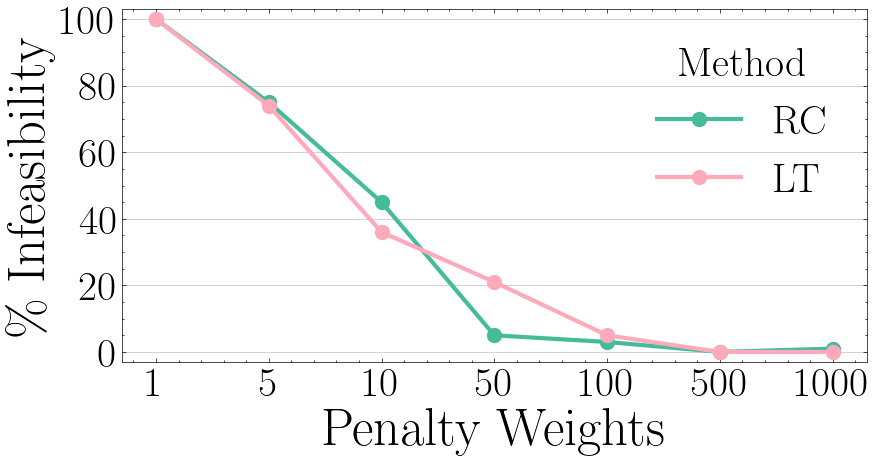

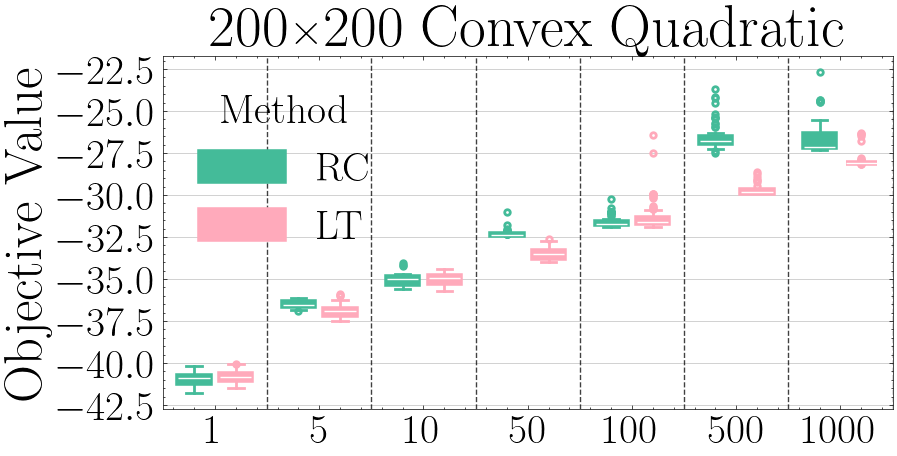

In [3]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="cq", size=200, penalties=penalties)

### 500x500

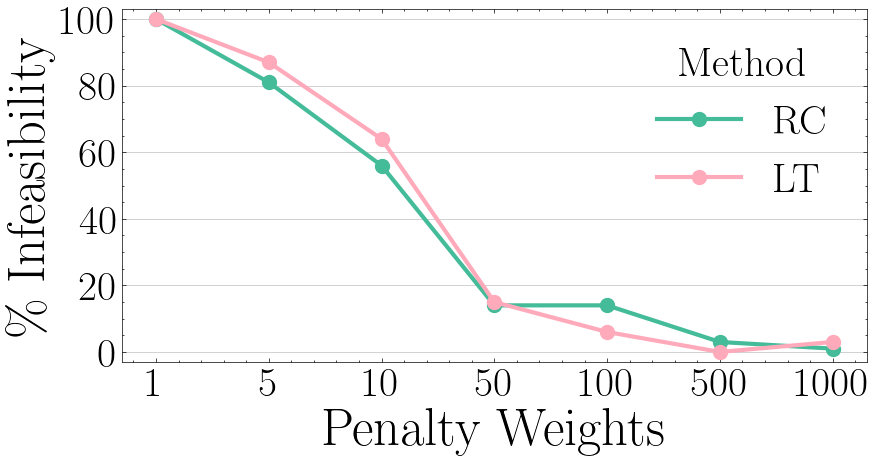

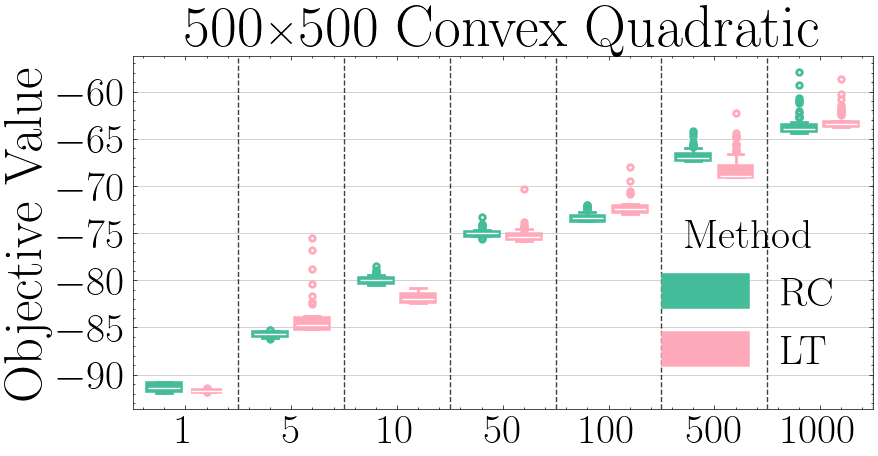

In [4]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="cq", size=500, penalties=penalties)

### 1000x1000

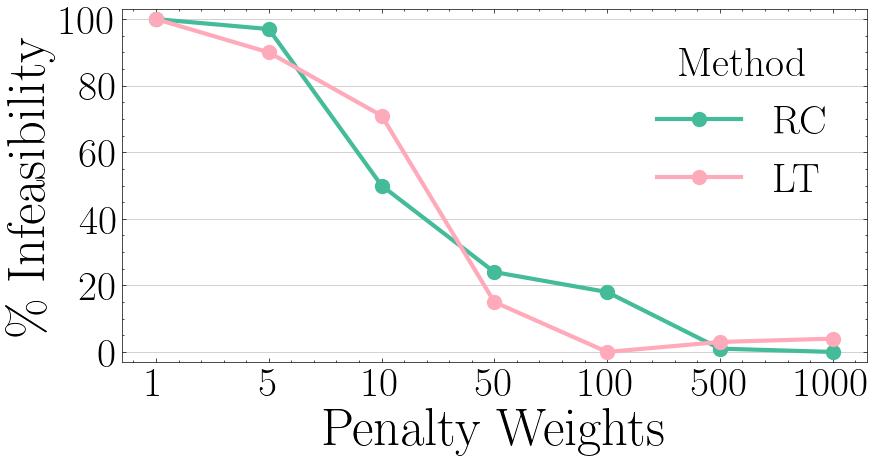

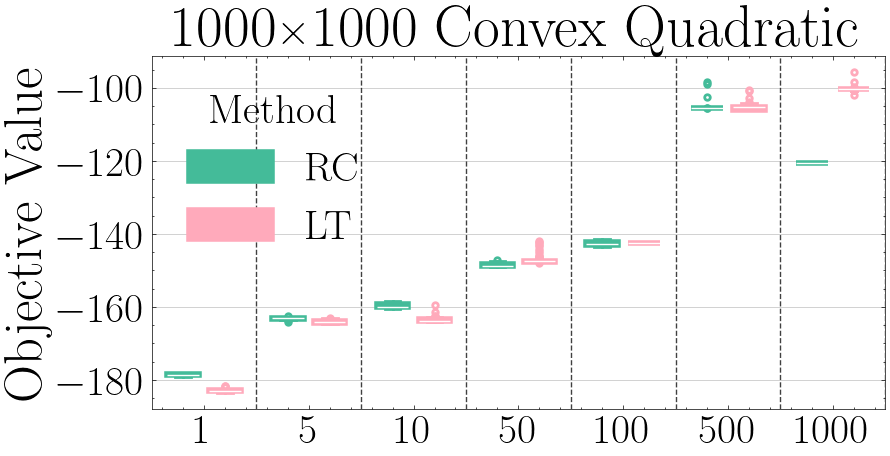

In [5]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="cq", size=1000, penalties=penalties)

### Simple Non-Convex

#### 200x200

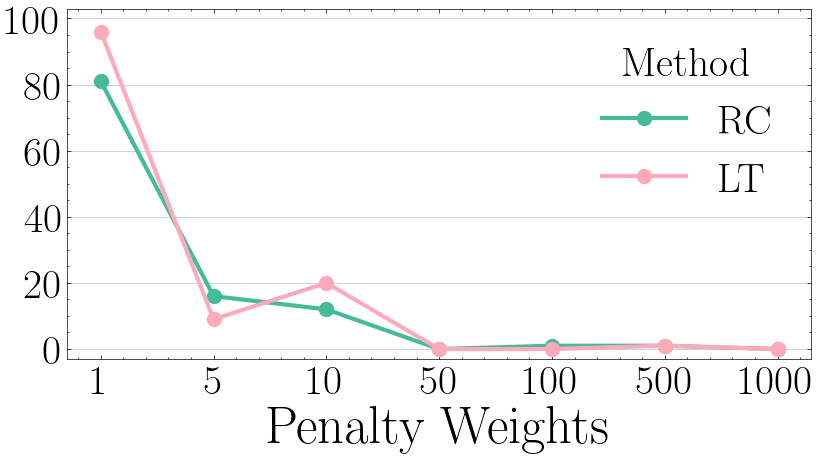

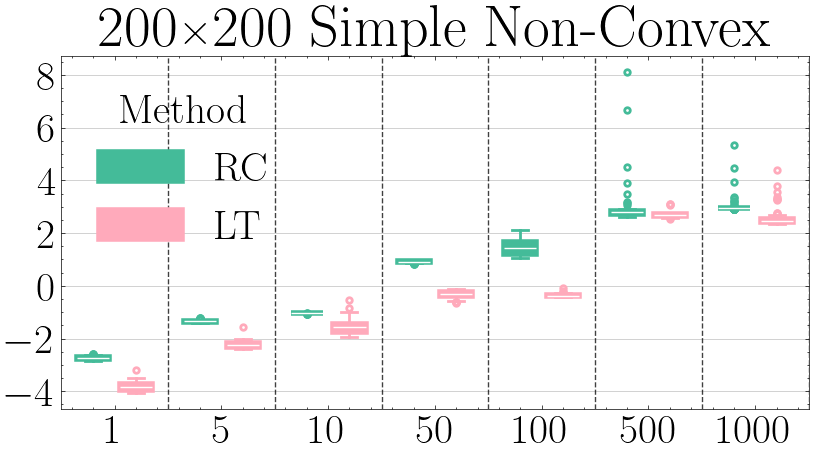

In [6]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="nc", size=200, penalties=penalties, new=True)

#### 500x500

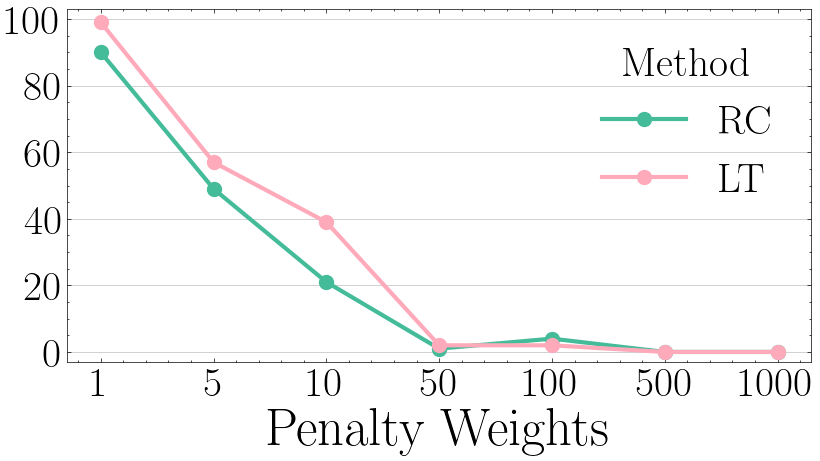

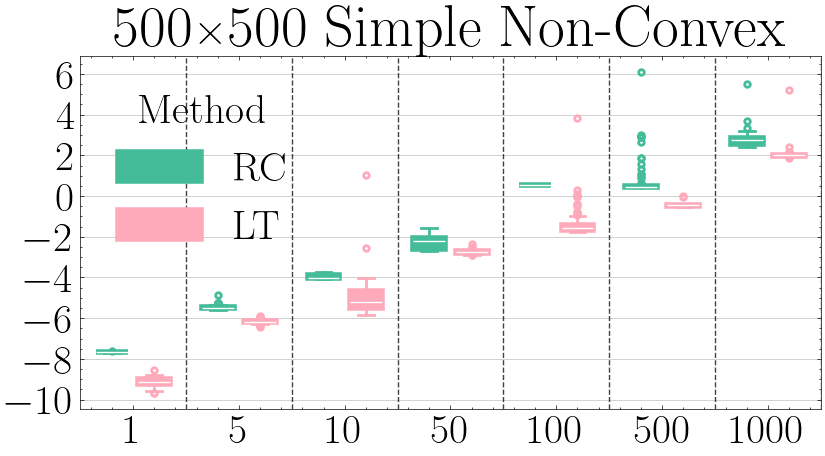

In [7]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="nc", size=500, penalties=penalties, new=True)

#### 1000x1000

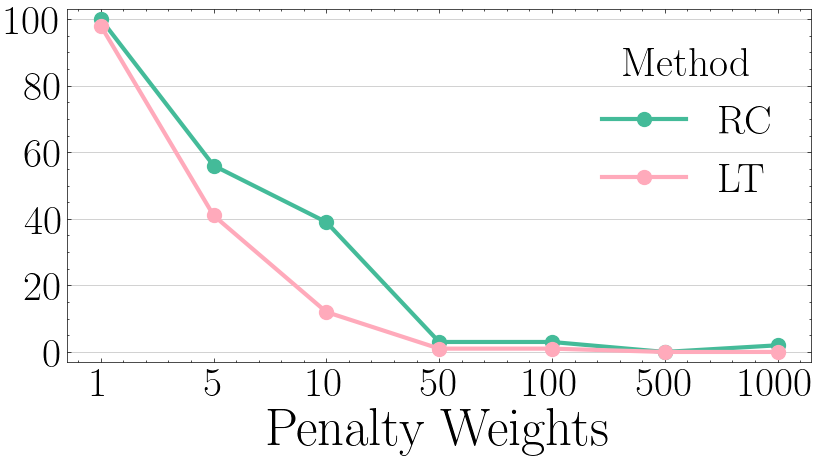

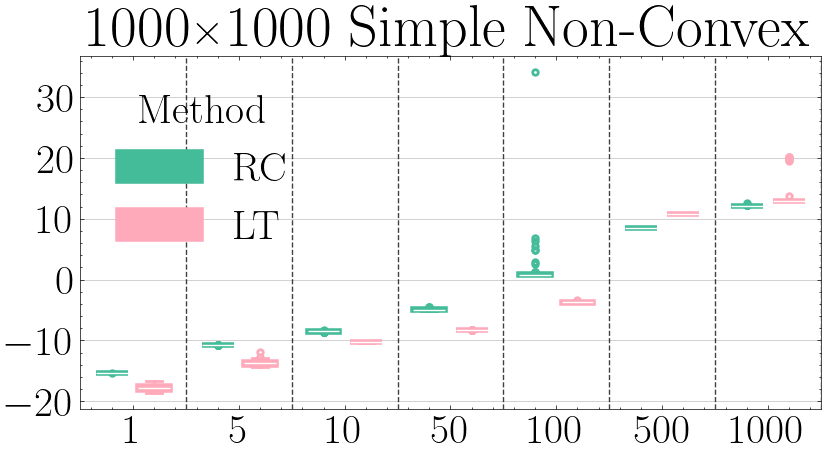

In [8]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="nc", size=1000, penalties=penalties, new=True)

### Rosenbrock

#### 1000x4

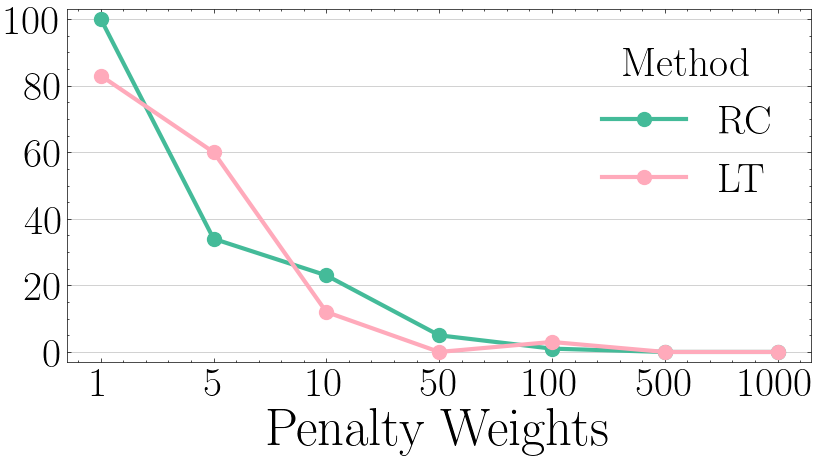

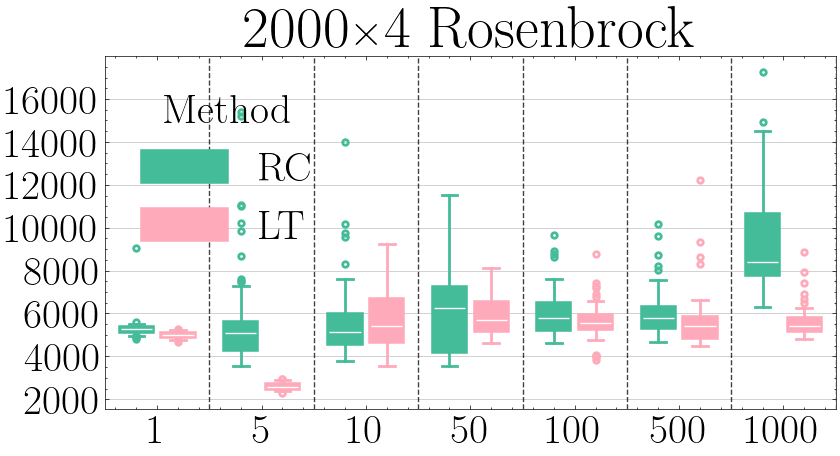

In [9]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="rb", size=1000, penalties=penalties)

#### 10000x4

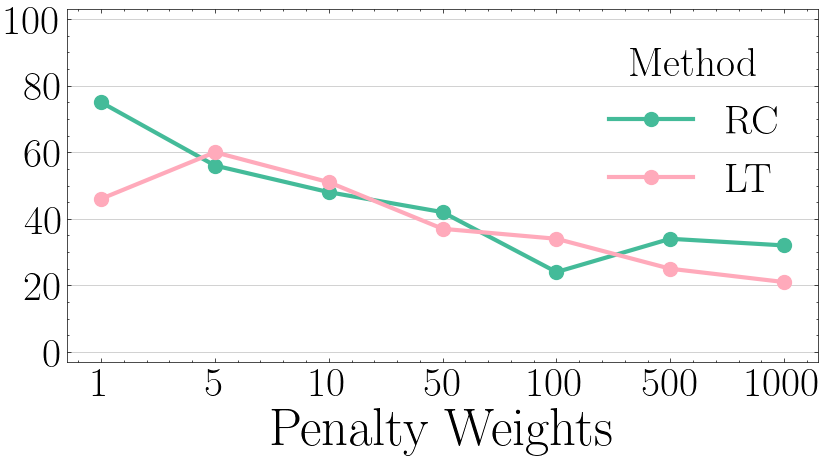

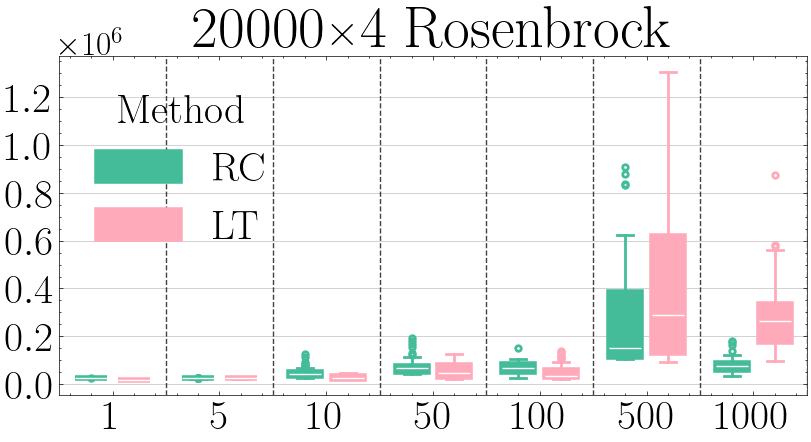

In [10]:
penalties = [1, 5, 10, 50, 100, 500, 1000]
plot(problem="rb", size=10000, penalties=penalties)